## Price elasticity calculation

This is a part of a big statistical project on factors that do or don't have an impact on the company's revenue.  
The results were tested using a t-test (since the data set follow a normal distribution) and p-value.

In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy import create_engine

In [ ]:
connection_string = ''
engine = create_engine(connection_string)

query_sales = """
    select mps.product_id,
       mps.date,
       mps.marketplace,
       mps.warehouse_name,
       mps.orders_quantity as sales_quantity,
       mps.orders_price_after_discount as sales_vol,
       mps.stocks_quantity,
       products.wb_date_from,
       products.oz_date_from,
       products.brand,
       products.wb_subject,
       min(products.date_from) over (partition by products.brand) brand_date_from
    from dm.product_warehouse_daily_stats_mp mps
        join dm.products products on products.article_id = mps.product_id
    where (mps.date >= products.wb_date_from and mps.marketplace='wildberries')
        or (mps.date >= products.oz_date_from and mps.marketplace='ozon')
"""

sales_init = pd.read_sql(query_sales, engine)
engine.dispose()

In [ ]:
sales = sales_init.copy()
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6179409 entries, 0 to 6179408
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   product_id       object 
 1   date             object 
 2   marketplace      object 
 3   warehouse_name   object 
 4   sales_quantity   float64
 5   sales_vol        float64
 6   stocks_quantity  float64
 7   wb_date_from     object 
 8   oz_date_from     object 
 9   brand            object 
 10  wb_subject       object 
 11  brand_date_from  object 
dtypes: float64(3), object(9)
memory usage: 565.7+ MB


In [ ]:
sales = sales.drop(['warehouse_name', 'stocks_quantity'], axis=1)
sales = sales.dropna(subset=['sales_vol']).reset_index(drop=True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3661266 entries, 0 to 3661265
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   product_id       object 
 1   date             object 
 2   marketplace      object 
 3   sales_quantity   float64
 4   sales_vol        float64
 5   wb_date_from     object 
 6   oz_date_from     object 
 7   brand            object 
 8   wb_subject       object 
 9   brand_date_from  object 
dtypes: float64(2), object(8)
memory usage: 279.3+ MB


In [ ]:
sales.head(10)

,product_id,date,marketplace,sales_quantity,sales_vol,wb_date_from,oz_date_from,brand,wb_subject,brand_date_from
0,FACT900158,2022-11-16,ozon,1.0,1110.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
1,FACT900158,2022-11-20,ozon,2.0,2220.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
2,FACT900158,2022-11-21,ozon,1.0,890.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
3,FACT900158,2022-11-22,ozon,1.0,1110.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
4,FACT900158,2022-11-22,ozon,1.0,1110.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
5,FACT900158,2022-11-24,ozon,1.0,910.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
6,FACT900158,2022-11-25,ozon,2.0,1713.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
7,FACT900158,2022-11-26,ozon,1.0,751.12,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
8,FACT900158,2022-11-26,ozon,1.0,910.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01
9,FACT900158,2022-11-27,ozon,1.0,910.00,2021-10-21,2021-10-22,Art&Fact,Тоники,2020-02-01


In [ ]:
sales['marketplace'].value_counts(normalize=True)

wildberries    0.908438
ozon           0.091562
Name: marketplace, dtype: float64

In [ ]:
sales['brand'].value_counts(normalize=True)

Art&Fact          0.741350
Shades of you     0.071019
Senseful          0.068491
Verifique         0.034496
Какава красота    0.028787
SAFE              0.028240
SCI.              0.020273
Let’s Bloom       0.007345
Name: brand, dtype: float64

In [ ]:
sales['wb_subject'].value_counts(normalize=True).head(10)

Сыворотки                         0.206072
Кремы                             0.154477
Косметические наборы для ухода    0.124719
Маски косметические               0.059471
Тоники                            0.057217
Пилинг                            0.055943
Спреи                             0.034013
Гели                              0.032352
Гели для бровей                   0.030459
Тинты для губ                     0.026493
Name: wb_subject, dtype: float64

In [ ]:
sales['product_id'].nunique()

437

In [ ]:
sales = sales.groupby(['product_id','date']).sum().reset_index()
sales['price'] = round(sales['sales_vol'] / sales['sales_quantity'], 2).fillna(method='ffill')
sales = sales.drop(['sales_vol'], axis=1)
sales.head(20)

,product_id,date,sales_quantity,price
0,900002,2020-02-28,3.0,635.00
1,900002,2020-02-29,3.0,635.00
2,900002,2020-03-01,2.0,635.00
3,900002,2020-03-02,2.0,635.00
4,900002,2020-03-03,3.0,619.67
5,900002,2020-03-04,1.0,612.00
6,900002,2020-03-05,6.0,612.00
7,900002,2020-03-06,1.0,612.00
8,900002,2020-03-07,2.0,612.00
9,900002,2020-03-08,1.0,612.00


In [ ]:
x_pivot = sales.pivot(index='date', columns='product_id', values='price')
x_values = pd.DataFrame(x_pivot.to_records())

y_pivot = sales.pivot(index='date', columns='product_id', values='sales_quantity')
y_values = pd.DataFrame(y_pivot.to_records())

df_elasticity = pd.DataFrame({
    'product_id': [],
    'price_elasticity': [],
    't_score': [],
    'p_value' : [],
    'slope': [],
    'intercept': [],
    'mean_price': [],
    'mean_quantity': [],
    'points_num': []
})

for product_id in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[product_id])):
        if not np.isnan(x_values[product_id][i]) and not np.isnan(y_values[product_id][i]):
            column_points.append((x_values[product_id][i], y_values[product_id][i]))
    df = pd.DataFrame(list(column_points), columns=['x_value', 'y_value'])

    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    if result.f_pvalue < 0.05:
        
        p_value = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        price_elasticity = slope * (mean_price / mean_quantity)
        
        product_values = {'product_id': product_id,
                          'price_elasticity': price_elasticity,
                          't_score': t_score,
                          'p_value': p_value,
                          'slope': slope,
                          'intercept': intercept,
                          'mean_price': mean_price,
                          'mean_quantity': mean_quantity,
                          'points_num': len(df)}            
        df_elasticity = df_elasticity.append(product_values, ignore_index=True)
        
df_elasticity['p_value'] = round(df_elasticity['p_value'], 6)
df_elasticity.head(10)

,product_id,price_elasticity,t_score,p_value,slope,intercept,mean_price,mean_quantity,points_num
0,900002,-1.754485,-13.029778,0.0,-0.305649,202.019994,420.997945,73.342202,1090.0
1,900005,-1.622918,-14.420722,0.0,-0.083591,63.173829,467.617927,24.085321,1090.0
2,900006,-2.005933,-12.016509,0.0,-0.070948,62.766095,590.371193,20.880734,1090.0
3,900007,-1.870197,-8.850578,0.0,-0.269724,184.635290,446.036495,64.328440,1090.0
4,900009,-1.193291,-6.830311,0.0,-0.021436,23.480291,595.958450,10.705505,1090.0
5,900010,-2.256566,-15.610383,0.0,-0.081830,55.582713,470.670706,17.067890,1090.0
6,ART&FACT900001,-3.334427,-17.180139,0.0,-1.491186,954.870375,492.608615,220.299083,1090.0
7,ART&FACT900003,-2.063707,-13.255538,0.0,-0.095815,73.919667,519.669248,24.127523,1090.0
8,FACT100267,-4.129164,-9.463936,0.0,-0.038261,56.652635,1192.010085,11.045198,354.0
9,FACT100268,-3.708451,-6.971986,0.0,-0.036288,56.168898,1219.124096,11.929379,354.0


In [ ]:
df_elasticity['price_elasticity'] = round(df_elasticity['price_elasticity'], 4)
df_elasticity['t_score_abs'] = round(abs(df_elasticity['t_score']), 2)
df_elasticity = df_elasticity[['product_id',
                               'price_elasticity',
                               't_score_abs',
                               'p_value',
                               'points_num']]
df_elasticity.head(10)

,product_id,price_elasticity,t_score_abs,p_value,points_num
0,900002,-1.7545,13.03,0.0,1090.0
1,900005,-1.6229,14.42,0.0,1090.0
2,900006,-2.0059,12.02,0.0,1090.0
3,900007,-1.8702,8.85,0.0,1090.0
4,900009,-1.1933,6.83,0.0,1090.0
5,900010,-2.2566,15.61,0.0,1090.0
6,ART&FACT900001,-3.3344,17.18,0.0,1090.0
7,ART&FACT900003,-2.0637,13.26,0.0,1090.0
8,FACT100267,-4.1292,9.46,0.0,354.0
9,FACT100268,-3.7085,6.97,0.0,354.0


<AxesSubplot:xlabel='price', ylabel='sales_quantity'>

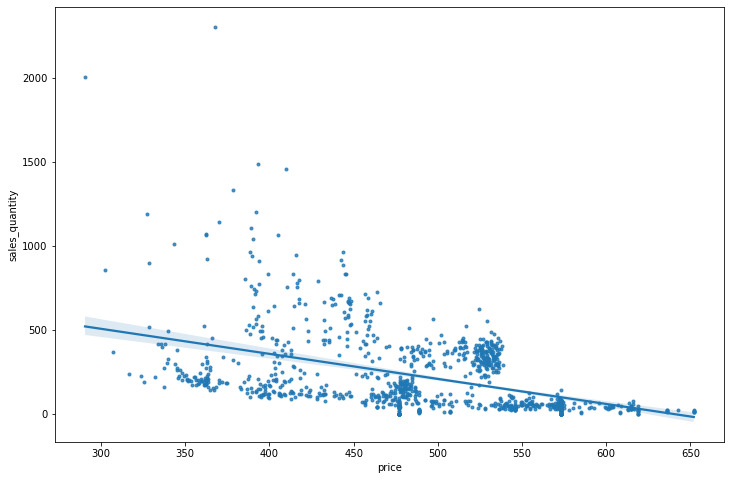

In [ ]:
product_id = 'ART&FACT900001'
df_plot = sales[sales['product_id'] == product_id].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(ax=ax, x="price", y="sales_quantity", data=df_plot, marker='.')

<AxesSubplot:xlabel='price', ylabel='sales_quantity'>

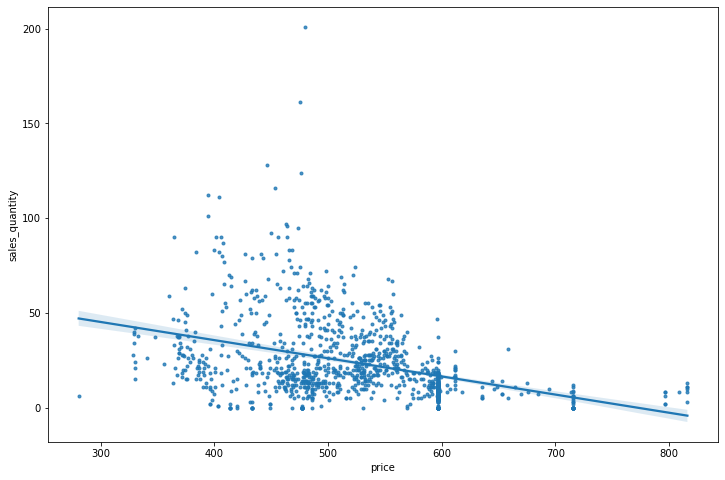

In [ ]:
product_id = 'ART&FACT900003'
df_plot = sales[sales['product_id'] == product_id].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(ax=ax, x="price", y="sales_quantity", data=df_plot, marker='.')

In [ ]:
# df_elasticity.to_excel('price_elasticity.xlsx', index=False)